In [1]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
import sys
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf

print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.16.1


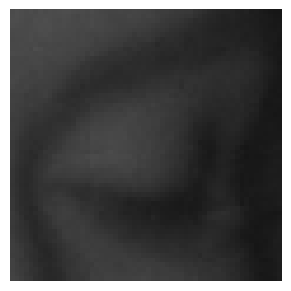

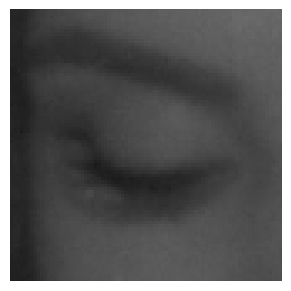

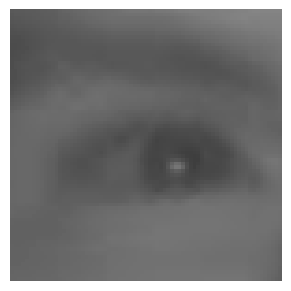

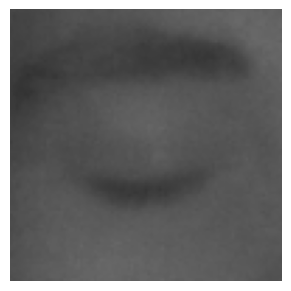

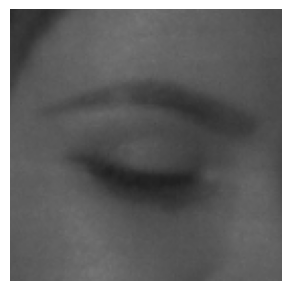

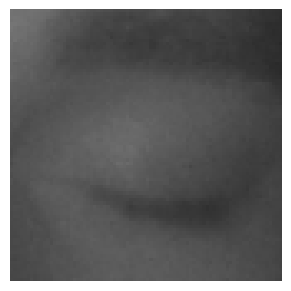

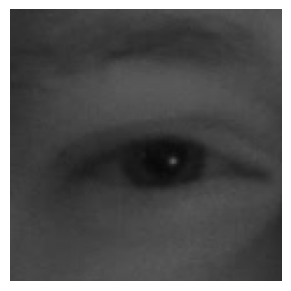

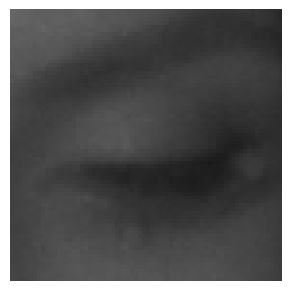

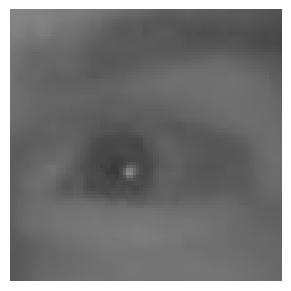

In [2]:
images = glob("mrlEyes_2018_01/train/**/**")
for i in range(9):
    image = random.choice(images)
    plt.figure(figsize = (12,12))
    plt.subplot(331 + i)
    plt.imshow(cv2.imread(image));  plt.axis('off')

In [3]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("mrlEyes_2018_01/train/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("mrlEyes_2018_01/test/",
                                                   target_size = (img_size, img_size),
                                                   color_mode = "grayscale",
                                                   batch_size = batch_size,
                                                   class_mode = "categorical",
                                                   shuffle = True)

Found 5917 images belonging to 2 classes.
Found 1199 images belonging to 2 classes.


In [4]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [5]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)
    
    return x

In [6]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv1 = Convolution(inputs, 32, (3,3))
    conv2 = Convolution(inputs, 64, (5,5))
    conv3 = Convolution(inputs, 128, (3,3))
    
    flatten = Flatten()(conv3)
    
    dense_1 = Dense_f(flatten, 256)
    
    output = Dense(2, activation = "sigmoid")(dense_1)
    model = Model(inputs = [inputs], outputs = [output])
    
    model.compile(loss = ['binary_crossentropy'], optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [7]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,877,954 (72.01 MB)

 Trainable params: 18,877,186 (72.01 MB)

 Non-trainable params: 768 (3.00 KB)

In [8]:
# file_path = r'C:\Users\shrey\OneDrive\Desktop\Emotional Detector\model.weights.h5'#.encode(sys.getfilesystemencoding()).decode()
epochs = 3
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint('model_1.weights.h5', monitor = 'val_accuracy', save_weights_only = True, mode = 'max', verbose = 1)
callbacks = [checkpoint]

In [11]:
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1}/{epochs}")
#     for data_batch, labels_batch in train_generator:
#         print(f"Data batch shape: {data_batch.shape}")
#         print(f"Labels batch shape: {labels_batch.shape}")
#         break  # Break after the first batch
#     history = model.fit(
#         x = train_generator,
#         steps_per_epoch = steps_per_epoch,
#         epochs = epochs,
#         validation_data = validation_generator,
#         validation_steps = validation_steps,
#         callbacks = callbacks
#     )
history = model.fit(
        x = train_generator,
        steps_per_epoch = steps_per_epoch,
        epochs = epochs,
        validation_data = validation_generator,
        validation_steps = validation_steps,
        callbacks = callbacks)

Epoch 1/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.9988 - loss: 0.0047
Epoch 1: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 75s 802ms/step - accuracy: 0.9988 - loss: 0.0047 - val_accuracy: 0.5799 - val_loss: 1.3508
Epoch 2/3
 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:08 748ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 2: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 6.6026e-04 - val_accuracy: 0.5745 - val_loss: 0.6500
Epoch 3/3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 843ms/step - accuracy: 0.9985 - loss: 0.0049
Epoch 3: saving model to model_1.weights.h5
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 870ms/step - accuracy: 0.9985 - loss: 0.0049 - val_accuracy: 0.3134 - val_loss: 4.9342


In [12]:
model.save("model_1.weights.h5")

In [13]:
# Get a batch of validation data and labels
validation_batch = next(validation_generator)

# Print the shapes
print(f"Validation data shape: {validation_batch[0].shape}")
print(f"Validation labels shape: {validation_batch[1].shape}")

Validation data shape: (64, 48, 48, 1)
Validation labels shape: (64, 2)


In [14]:
model.evaluate(validation_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 827ms/step - accuracy: 0.3104 - loss: 4.8383


[4.927903652191162, 0.3144286870956421]

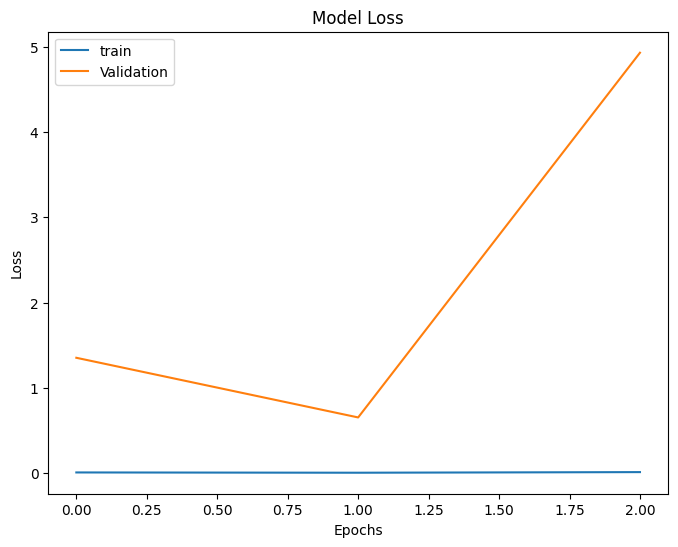

In [15]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title("Model Loss")
plt.legend(['train','Validation'], loc = 'upper left')
# plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.legend()
plt.show()

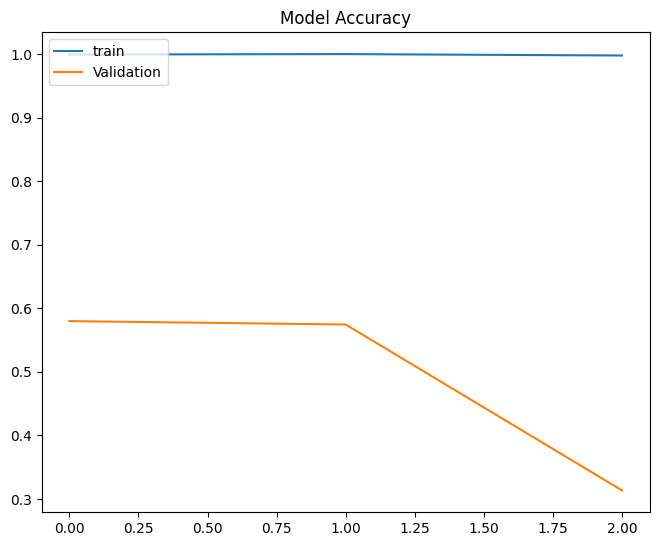

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(['train','Validation'], loc = 'upper left')
plt.subplots_adjust(top = 1.0, bottom = 0.0, right = 0.95, left = 0.0, hspace = 0.25, wspace = 0.35)

In [17]:
model_json = model.to_json()
with open("model_1_a.json", "w") as json_file:
    json_file.write(model_json)